<a href="https://colab.research.google.com/github/SimoneCallegarin/NLP_project/blob/main/NSP_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NSP Datasets

## Setup the Envirnoment

Import necessary libaries.

In [145]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

Download the original dataset from the [repository](https://github.com/SimoneCallegarin/NLP_project/blob/main/Data/EDOS_1M.csv)

In [146]:
csv_path_initial = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/Data/EDOS_1M.csv"

In [147]:
df = pd.read_csv(csv_path_initial)

## Dialogues Analysis

Analyze how dialogues are structured in the dataset in order to perform a better preprocessing phase.

In [148]:
# Get the dialogue_id values for rows that occur only once
unique_dialogue_ids = df['dialogue_id'].value_counts()[df['dialogue_id'].value_counts() == 1].index.tolist()

# Filter the DataFrame to rows with unique dialogue_id values
unique_dialogue_id_rows = df[df['dialogue_id'].isin(unique_dialogue_ids)]

if len(unique_dialogue_id_rows) > 0:
    print("There are rows with unique dialogue_id values:")
    print(unique_dialogue_id_rows)
else:
    print("There are no rows with unique dialogue_id values (no dialogues with just 1 utterance).")

There are no rows with unique dialogue_id values (no dialogues with just 1 utterance).


In [149]:
df['eb+_emot'].value_counts()[:7]

questioning      841556
furious          169917
acknowledging    138165
trusting         134197
wishing          108668
suggesting       101591
anticipating     100433
Name: eb+_emot, dtype: int64

Looking to the emotions distribution we can see that it is not homogeneous, due to a prevalence of *questioning* emotions.

Now let's see how many utterances per dialogues there are.

In [150]:
max_turns = df.groupby('dialogue_id')['turn'].transform('max')

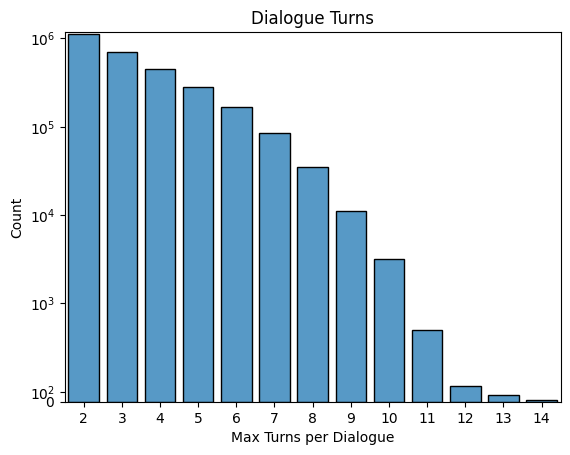

In [151]:
sns.countplot(x=max_turns, facecolor='#5799C6', linewidth=1, edgecolor='black')
plt.xlabel('Max Turns per Dialogue')
plt.ylabel('Count')
plt.title('Dialogue Turns')
plt.yscale('symlog', linthresh=1000)
plt.show()

In [152]:
max_turns.value_counts()

2     1112198
3      693840
4      444064
5      281300
6      164784
7       83636
8       34440
9       11043
10       3160
11        726
12        156
13         65
14         14
Name: turn, dtype: int64

It appears that the dataset contains mostly short dialogues.

## Preprocessing

In [153]:
df_filtered = df

Remove dialogues that contains 2 or less utterances.

In [154]:
# Get the dialogue_id values where turn > 2
dialogues_longer_than_2 = df_filtered.loc[df_filtered['turn'] > 2, 'dialogue_id'].unique()

# Filter out the rows where turn <= 2 for each dialogue_id
df_filtered = df_filtered[df_filtered['dialogue_id'].isin(dialogues_longer_than_2)]

Reduce the number of dialogues containing 'questioning' utterances in order to make the distribution of the emotions more homogeneous.

In [155]:
# Select the number of dialogues containing questioning utterances to mantain
questioning_dialogues_to_mantain = 40000

In [156]:
# Get the dialogue_id values where eb+_emot == 'questioning'
questioning_dialogues = df_filtered.loc[df_filtered['eb+_emot'] == 'questioning', 'dialogue_id'].unique()

# Get the dialogue_id of the dialogues conatining 'questioning' that has to be removed
questioning_dialogues_to_remove = questioning_dialogues[:(len(questioning_dialogues)-questioning_dialogues_to_mantain)]

# Filter out the exceeding dialogues containing 'questioning' for each dialogue_id
df_filtered = df_filtered[~df_filtered['dialogue_id'].isin(questioning_dialogues_to_remove)]

# Reset the index of the filtered DataFrame
df_filtered = df_filtered.reset_index(drop=True)

In [157]:
df_filtered['eb+_emot'].value_counts()[:7]

questioning      67362
furious          48993
trusting         35149
acknowledging    34734
wishing          31575
suggesting       26730
anticipating     25109
Name: eb+_emot, dtype: int64

Now the distribution looks more uniform.

## Split Dialogues into Two Senteces

In [158]:
final_df = df_filtered[['dialogue_id','turn','uttr']]

Split each dialogue in two sentences:
- the first will contain the first half of the utterances
- the second will have the second half of the utterances

In [159]:
# Store the number of turns of each dialogue
max_turns = final_df.groupby('dialogue_id')['turn'].transform('max')

# Create the datasets
first_half = final_df.loc[final_df['turn'] <= (max_turns+1)//2, ['dialogue_id','turn', 'uttr']]
second_half = final_df.loc[~(final_df.index.isin(first_half.index)), :]

In [160]:
first_half = first_half.reset_index(drop=True)
first_half

,dialogue_id,turn,uttr
0,217,1,Your medicine . Open your mouth .
1,217,2,Granny ...
2,500,1,"Hi there , Welcome to the Stockroom ."
3,500,2,I don 't really work here . I 've never even b...
4,675,1,I 'm gonna fuckin ' kill him . Wait your turn .
...,...,...,...
351031,8820571,1,Trying to force a nun back to the convent when...
351032,8820571,2,That seems to be your game . What 's that supp...
351033,8820621,1,Well .. .. this is just the way it was suppose...
351034,8820621,2,"Well then , great ."


In [161]:
second_half = second_half.reset_index(drop=True)
second_half

,dialogue_id,turn,uttr
0,217,3,Don 't spill it .
1,500,3,Don 't get me wrong . I 'm not a prude . I lik...
2,500,4,Shut up bitch ! Show us the butt plugs . Butt ...
3,675,3,"You motherfucker ! No , no ! Hold on ! What th..."
4,753,3,So I thought to myself ... I didn 't understan...
...,...,...,...
232583,8820065,4,Maybe . I think it would be better not to die .
232584,8820065,5,"Don 't you , doctor ?"
232585,8820571,3,"Well , for example , right now , by the nature..."
232586,8820621,4,It 's negative ?


### Check the Correctness

Check if the number of dialogues in the starting dataframe and in the other two that have been producedd is the same.

In [162]:
len(final_df['dialogue_id'].unique()) == len(first_half['dialogue_id'].unique()) == len(second_half['dialogue_id'].unique())

True

Now let's see how the algorithm works with an example using the dialogue with more turns.

In [163]:
max_turn = final_df['turn'].max()
max_turn

13

In [164]:
row_with_max_turn = final_df.loc[final_df['turn'] == max_turn]

In [165]:
row_with_max_turn

,dialogue_id,turn,uttr
227854,2848381,13,I believe in children eating Their breakfast a...
553527,7010226,13,Why did you come ?


In [166]:
first_dialogue = first_half.loc[first_half['dialogue_id'] == row_with_max_turn['dialogue_id'].values[0]]
first_dialogue

,dialogue_id,turn,uttr
139339,2848381,1,"Good morning , father ."
139340,2848381,2,"Good morning , Darling ."
139341,2848381,3,"Good morning , Aunt Josephine ."
139342,2848381,4,"Good morning , Kitty ."
139343,2848381,5,"Good morning , Lawrence ."
139344,2848381,6,"Goodbye , Aunt josephine ."
139345,2848381,7,"Goodbye , Kitty . Have a good time ."


In [167]:
second_dialogue = second_half.loc[second_half['dialogue_id'] == row_with_max_turn['dialogue_id'].values[0]]
second_dialogue

,dialogue_id,turn,uttr
88503,2848381,8,I will !
88504,2848381,9,Take good care Of yourself !
88505,2848381,10,I will !
88506,2848381,11,"Goodbye , darling ! Goodbye !"
88507,2848381,12,"Must we have A draft , Henry ?"
88508,2848381,13,I believe in children eating Their breakfast a...


The algorithm correctly split the dialogue into two parts, exactly in half.

##  Generate a Dataframe with other Random Dialogues 

From the original dataset we produced a dataframe containing all the other dialogues that were not involved in the *first_sentences* and *second_sentences* dataframes.

In [168]:
# Get the dialogue_id values for rows that occur only once
taken_dialogues = final_df['dialogue_id'].unique()

# Filter the DataFrame to rows with unique dialogue_id values
wrong_sentences = df[~df['dialogue_id'].isin(taken_dialogues)]

### Preprocess

In [169]:
wrong_sentences['eb+_emot'].value_counts()[:7]

questioning      774194
furious          120924
acknowledging    103431
trusting          99048
wishing           77093
anticipating      75324
suggesting        74861
Name: eb+_emot, dtype: int64

The distribution of the emotions over this dataset is quite unbalanced, so as before, we filter out some dialogues that contains the *questioning* emotion.

In [170]:
questioning_dialogues_to_mantain = 65000

In [171]:
# Get the dialogue_id values where eb+_emot == 'questioning'
questioning_dialogues = wrong_sentences.loc[wrong_sentences['eb+_emot'] == 'questioning', 'dialogue_id'].unique()

# Get the dialogue_id of the dialogues conatining 'questioning' that has to be removed
questioning_dialogues_to_remove = questioning_dialogues[:(len(questioning_dialogues)-questioning_dialogues_to_mantain)]

# Filter out the exceeding dialogues containing 'questioning' for each dialogue_id
wrong_sentences = wrong_sentences[~wrong_sentences['dialogue_id'].isin(questioning_dialogues_to_remove)]

# Reset the index of the filtered DataFrame
wrong_sentences = wrong_sentences.reset_index(drop=True)

In [172]:
wrong_sentences['eb+_emot'].value_counts()[:7]

questioning      84760
furious          58234
trusting         44940
acknowledging    43890
wishing          39806
anticipating     36286
suggesting       34432
Name: eb+_emot, dtype: int64

Now the distribution looks quite homogeneous.

### Split the Utterances Randomly

For each dialogue we select the first randomic utterances in order to put them togheter next.

In [173]:
# Store the turns of each dialogue in the wrong_sentences dataframe
max_turns = wrong_sentences.groupby('dialogue_id')['turn'].transform('max')

# Generate a list of random integers between 1 and max_turn for each row 
random_ints = [random.randint(0, max_turn-1) for max_turn in max_turns]

# Subtract the random integers from the max_turns values
max_turns = max_turns - random_ints

In [174]:
wrong_sentences = wrong_sentences.loc[wrong_sentences['turn'] <= max_turns, ['dialogue_id','turn', 'uttr']]

In [175]:
wrong_sentences

,dialogue_id,turn,uttr
0,97,1,You moron ! What fool washes diapers by the we...
1,97,2,You useless fool !
2,99,1,How dare you sleep !
4,100,1,Clean the kitchen .
5,100,2,"I cleaned the kitchen , ma 'am ."
...,...,...,...
740237,8819565,1,What is it about you ... that drives me crazy ...
740238,8819565,2,I 've never been able to igure out ... but thi...
740239,8819998,1,"Hello , Mr. Hindle . Follow your heart ."
740241,8820637,1,Thank God !


## Merge the Utterances togheter

Let's now merge the utterances of the same dialogues togheter.

In [176]:
first_sentences = first_half.groupby('dialogue_id')['uttr'].agg(' '.join).reset_index()
second_sentences = second_half.groupby('dialogue_id')['uttr'].agg(' '.join).reset_index()
wrong_sentences = wrong_sentences.groupby('dialogue_id')['uttr'].agg(' '.join).reset_index()

In [177]:
first_sentences

,dialogue_id,uttr
0,76,Granny . Don 't tell anyone . Keep it . That '...
1,200,How about Oshin ? Oshin .
2,217,Your medicine . Open your mouth . Granny ...
3,355,"Sir , I 'd like some private moment with my mo..."
4,379,What the hell ? No one 's here . Dammit ! Chie...
...,...,...
162094,8820466,"There 's another . It 's not happy , exactly ...."
162095,8820525,"Minister , I really think I should sign as wel..."
162096,8820568,"Father , it 's God 's work . No , it is this w..."
162097,8820571,Trying to force a nun back to the convent when...


In [178]:
second_sentences

,dialogue_id,uttr
0,76,"Granny , thank you so much . Hey ! She 's ready ."
1,200,"Thank you , ma 'am !"
2,217,Don 't spill it .
3,355,Okay . Until midnight . Thank you .
4,379,So he did live here . Maybe he got tipped off ...
...,...,...
162094,8820466,Then let 's give it a try . You feel ready ? J...
162095,8820525,"Okay , Buckbeak . Come quickly . Come with us ..."
162096,8820568,"Yes , yes . God kept you here . He brought us ..."
162097,8820571,"Well , for example , right now , by the nature..."


Check the correctness of the dataframes produced: *first_sentences* and *second_sentences* must have an equal number of dialogues.

In [179]:
len(first_sentences) == len(second_sentences) == len(final_df['dialogue_id'].unique())

True

In [180]:
wrong_sentences

,dialogue_id,uttr
0,1,"So , let 's take a look at what 's going on ar..."
1,53,Good for you ! That 's a big piece . Is it yum...
2,68,Is this rice ? It 's your pay for a year . You...
3,84,It 's breakfast time ! You must be hungry .
4,97,You moron ! What fool washes diapers by the we...
...,...,...
352747,8820579,Bring her back to him .
352748,8820594,"Okay , so we 're cool . We 're going to be gre..."
352749,8820596,"Check it out , the "" Chan-Chan Man "" ! I 'm st..."
352750,8820631,"Wow , I can 't believe that 's our baby ."


### Combine Correlated and Not Correlated Responses

Concatenate the dataframes *second_sentences* and *wrong_sentences* in order to obtain a unique dataset containing correlated sentences to the *first_sentences* dataframe and other sentences that are not correlated.
This is done in order to be able to train NSP on the dataset.

In [181]:
secondXwrong_sentences = pd.concat([second_sentences, wrong_sentences])

# Sort the resulting dataframe by 'dialogue_id'
secondXwrong_sentences = secondXwrong_sentences.sort_values(by='dialogue_id')

In [182]:
secondXwrong_sentences

,dialogue_id,uttr
0,1,"So , let 's take a look at what 's going on ar..."
1,53,Good for you ! That 's a big piece . Is it yum...
2,68,Is this rice ? It 's your pay for a year . You...
0,76,"Granny , thank you so much . Hey ! She 's ready ."
3,84,It 's breakfast time ! You must be hungry .
...,...,...
352748,8820594,"Okay , so we 're cool . We 're going to be gre..."
352749,8820596,"Check it out , the "" Chan-Chan Man "" ! I 'm st..."
162098,8820621,"It 's negative ? No , it 's positive ."
352750,8820631,"Wow , I can 't believe that 's our baby ."


## Download the Resulting Datasets

In [183]:
first_sentences.to_csv('first_sentences.csv', index=False)
files.download('first_sentences.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [184]:
secondXwrong_sentences.to_csv('second_sentences.csv', index=False)
files.download('second_sentences.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>